# How to Validate Regression Models with Marginal Model Plots
John Bonfardeci <jbonfardeci@definitivelogic.com><br/>
2020-07-20<br/>
Adapted from <i>Sanford Weisberg, Applied Linear Regression</i>, 3rd Edition, pp. 185-190, 2005

In [58]:
import pandas as pd
from matplotlib import pyplot as plt
%matplotlib inline
import statsmodels.formula.api as sm
import numpy as np
import seaborn as sns

In [110]:
from statsmodels.nonparametric.smoothers_lowess import lowess

def mmp(x, yhat, actual, title):
    """
    Marginal Model Plots for Binary Model Fit Validation
    Based on methodology established by Weisberg, 2005.
    """
    yhat = lowess(endog=yhat, exog=x, frac=1.0/3, it=0)
    x1 = yhat[:,0]
    y1 = yhat[:,1]

    Y = lowess(endog=actual, exog=x, frac=1.0/3, it=0)
    x2 = Y[:,0]
    y2 = Y[:,1]
    
    fig1, ax1 = plt.subplots(figsize=(7, 7))
    ax2 = ax1.twinx()
    ax1.plot(x1, y1, color='blue', alpha=0.7)
    ax2.plot(x2, y2, color='red', alpha=0.7)
    ax2.set_yticks([])
    ax1.set_title(title, fontsize=18)
    ax1.set_ylabel('Y & Y-hat', fontsize=18)
    ax1.set_xlabel('X', fontsize=18)

    # add legend
    ax1.text(0.98, 0.90, '- Actual', fontsize=18, color='red'
            , transform=ax1.transAxes
            , horizontalalignment='right'
            , bbox=dict(fc='white', alpha=0.5, color='white'))
    
    ax1.text(0.98, 0.85, '- Predicted', fontsize=18, color='blue'
            , transform=ax1.transAxes
            , horizontalalignment='right'
            , bbox=dict(fc='white', alpha=0.5, color='white'))
    plt.savefig('./output/'+title)
    plt.show()

In [119]:
solar_data = pd.read_csv('./data/merged_solar_plant_data.csv')
solar_data.head()

,plant_id,date,mean_dc,mean_ac,mean_daily_yield,mean_total_yield,mean_amb_temp,mean_mod_temp,mean_irr
0,4135001,5/15/2020,2879.856266,281.899160,2586.279926,6.856087e+06,27.430823,32.582964,0.204699
1,4136001,5/15/2020,318.951020,311.692697,3826.512932,6.447034e+08,30.565992,35.559493,0.300622
2,4135001,5/16/2020,3002.139358,293.877881,3464.273323,6.863167e+06,26.780538,31.858851,0.211951
3,4136001,5/16/2020,268.390076,262.430616,3425.500902,6.377676e+08,29.478612,35.143314,0.246631
4,4135001,5/17/2020,3200.565600,312.961832,3695.106669,6.869208e+06,26.686727,32.740435,0.238869


## Linear Regression

In [126]:
# Split data into 70%/30% training/validation sets.
val_df = solar_data.sample(frac=0.3, random_state=123)
train_df = solar_data.drop(val_df.index)

ols = sm.ols("mean_ac ~ mean_dc + mean_irr", data=train_df)
ols_results = ols.fit()
ols_results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                mean_ac   R-squared:                       0.908
Model:                            OLS   Adj. R-squared:                  0.903
Method:                 Least Squares   F-statistic:                     183.4
Date:                Tue, 20 Jul 2021   Prob (F-statistic):           6.29e-20
Time:                        21:32:29   Log-Likelihood:                -168.67
No. Observations:                  40   AIC:                             343.3
Df Residuals:                      37   BIC:                             348.4
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     56.3690     12.624      4.465      0.000      30.790      81.948
mean_dc        0.0224      0.002     11.331      0.000       0.018       0.026
mean_irr     787.4156     54.596     14.422      0.000     676.793     898.038
==============================================================================
Omnibus:                        8.736   Durbin-Watson:                   2.238
Prob(Omnibus):                  0.013   Jarque-Bera (JB):                7.995
Skew:                           0.829   Prob(JB):                       0.0184
Kurtosis:                       4.431   Cond. No.                     3.82e+04
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 3.82e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

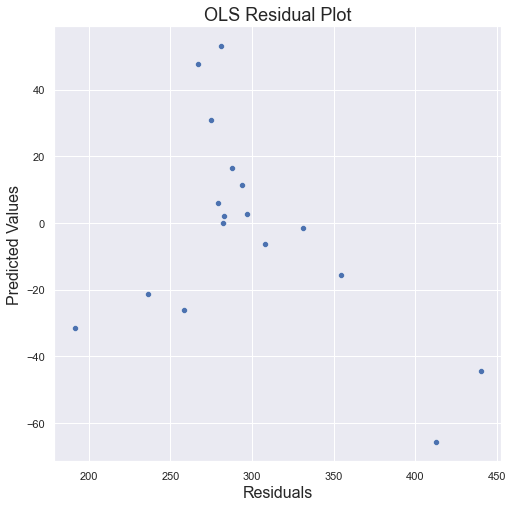

<Figure size 576x576 with 0 Axes>

In [133]:
predicted = ols_results.predict(val_df[['mean_dc', 'mean_irr']])
resid = np.subtract(predicted, val_df.mean_ac)

sns.set(rc={
    'figure.figsize' : (8, 8), 
    'axes.labelsize' : 16
})

resid_plot = sns.scatterplot(x=predicted, y=resid)
resid_plot.set(xlabel='Residuals', ylabel='Predicted Values')
plt.title('OLS Residual Plot', size=18)
plt.show()
plt.savefig('./ols_resid_plot.png')

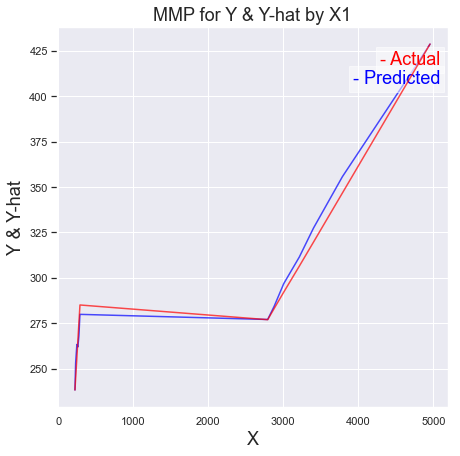

In [134]:
mmp(val_df.mean_dc, predicted, val_df.mean_ac, 'MMP for Y & Y-hat by X1')

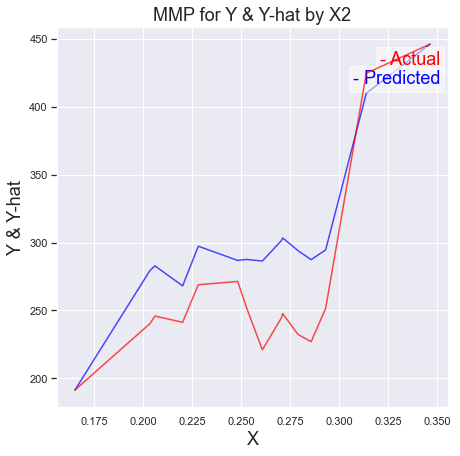

In [135]:
mmp(val_df.mean_irr, predicted, val_df.mean_ac, 'MMP for Y & Y-hat by X2')

## Classification

In [3]:
data = pd.read_csv('./data/fraud-logit-validation.csv').sample(frac=0.10, random_state=42)
drop_col = data.columns[0]
data.drop(drop_col, axis=1, inplace=True)
data.head()

,V1,V4,V7,V10,V13,V14,V18,V22,V23,V26,V28,Class,prob,yhat
17855,1.095921,0.713989,-0.911560,-0.069098,-1.618913,0.128026,0.001607,0.030152,0.067313,0.334696,0.010096,0,0.00,0
23775,-0.741505,4.690920,-0.948289,1.071885,0.083203,-1.488705,0.775045,0.564897,-0.300123,0.642417,-0.101744,0,0.00,0
18629,2.017591,0.210923,-0.073128,0.292050,-2.110173,0.884010,-0.035674,-0.837225,0.289000,0.219547,-0.077962,0,0.00,0
12843,-1.581798,3.427096,5.839506,-0.617252,-0.812960,-1.278568,0.800565,1.109623,1.226622,-0.185940,-0.242989,0,0.01,1
18084,2.062561,0.520507,0.378608,-0.517028,1.573020,-1.042816,0.302524,0.873694,-0.036108,-0.109039,-0.028062,0,0.00,0


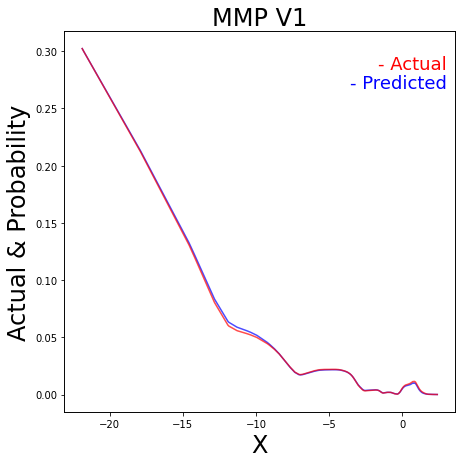

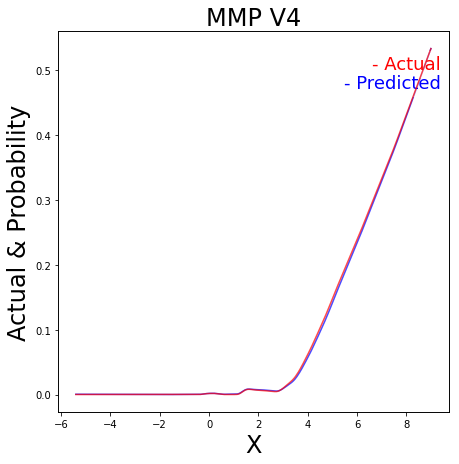

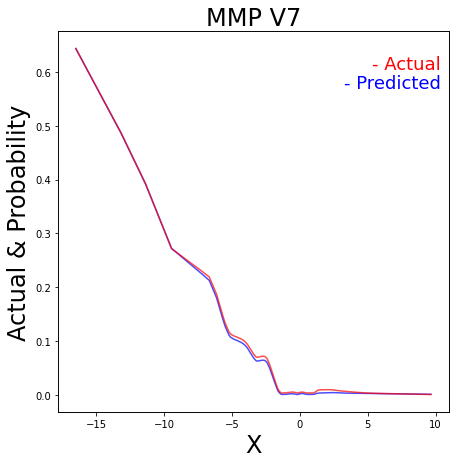

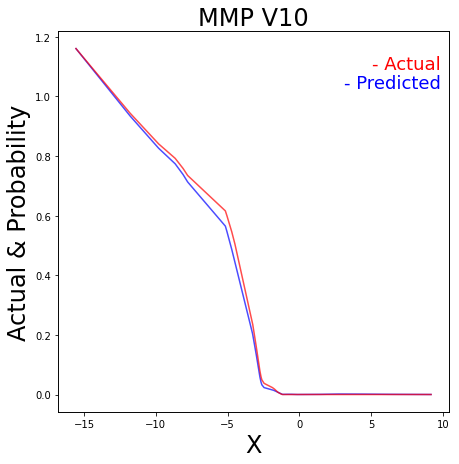

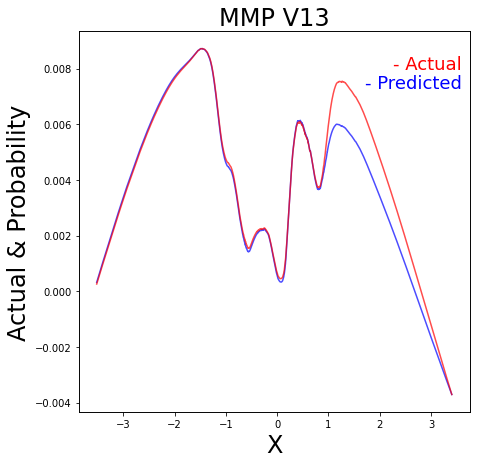

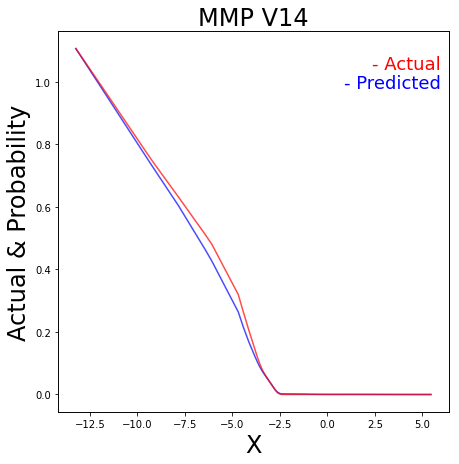

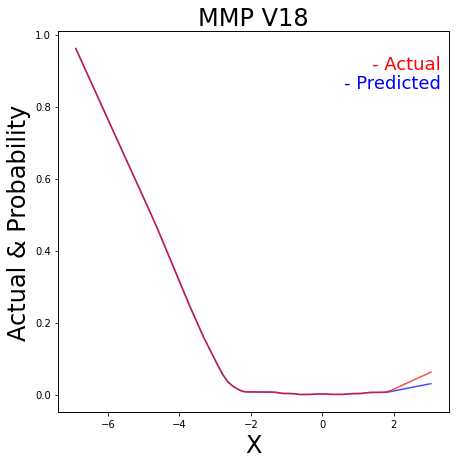

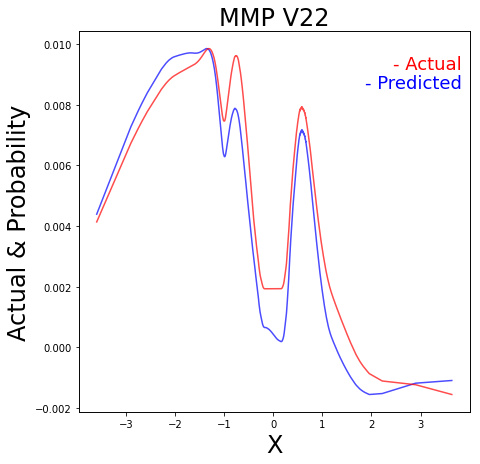

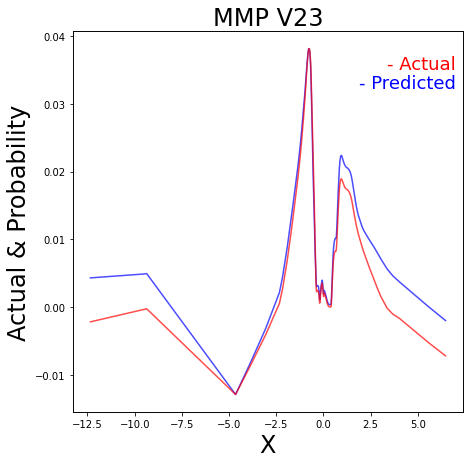

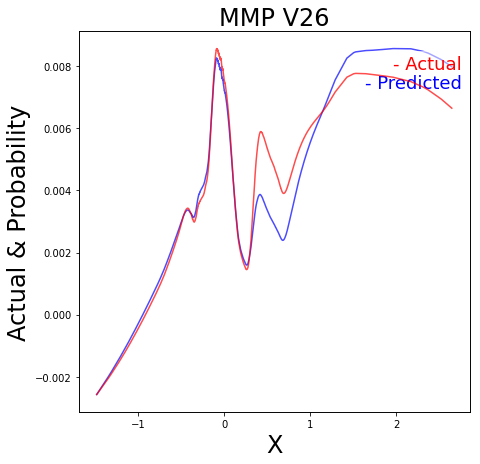

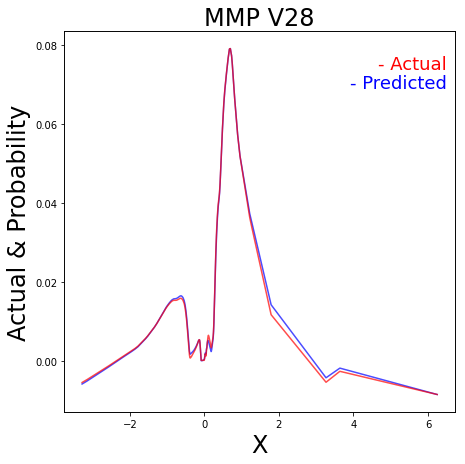

In [19]:
for col in data.drop(['Class', 'prob', 'yhat'], 1).columns:
    mmp(data[col], data.prob, data.Class, 'MMP '+col)